In [1]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.imaging_utils import *

In [2]:
beam_dir = '../configs/beams/dish_RealG_patterns/'
freq_list = ['1', '1_5', '2', '2_5', '3']
freq_np = np.array([1., 1.5, 2., 2.5, 3.])
n_freq = len(freq_list)

beam_list_db = [np.loadtxt(beam_dir + 'dish_RealG_pattern_{}GHz.txt'.format(f)) for f in freq_list]

In [3]:
# Normalise the beams
norm_beam_list_db = [beam - np.array([0., np.max(beam[:,1])]) for beam in beam_list_db]
# Beam gain in linear scale
norm_beam_list_gain = [10**(beam[:,1]/20) for beam in norm_beam_list_db]
# Append linear scale gain to the beam data
norm_beam_list = [np.column_stack((beam, gain)) for beam, gain in zip(norm_beam_list_db, norm_beam_list_gain)]

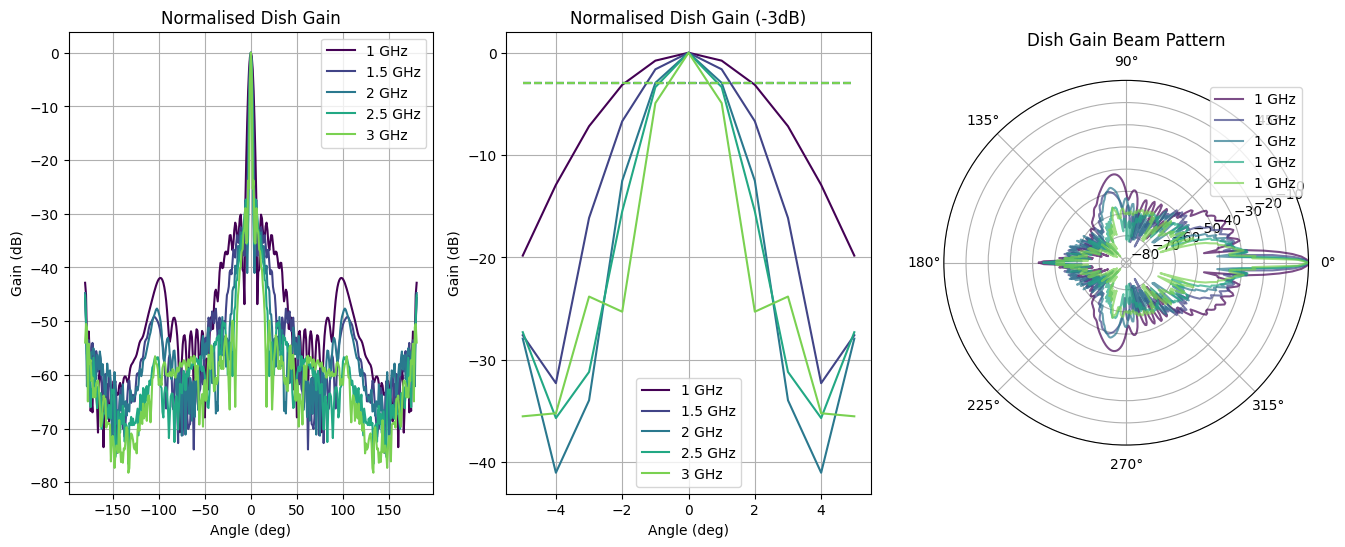

In [4]:
cmap = plt.get_cmap('viridis')
freq_labels = ['1 GHz', '1.5 GHz', '2 GHz', '2.5 GHz', '3 GHz']

# Plot the beam
fig= plt.figure(figsize=(16,6))
ax = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3, polar=True)]

bm_centre = norm_beam_list[0].shape[0]//2
bm_width = 5
for i, beam in enumerate(norm_beam_list):
    color_ = cmap(i/n_freq)
    ax[0].plot(beam[:,0], beam[:,1], label=freq_labels[i], color=color_)
    ax[1].plot(beam[bm_centre-bm_width:bm_centre+bm_width+1 ,0], beam[bm_centre-bm_width:bm_centre+bm_width+1 ,1], label=freq_labels[i], color=color_)
    ax[1].hlines(np.max(beam[:,1])-3, -5, 5, linestyle='--', color=color_)
    ax[2].plot(np.deg2rad(beam[:,0]), beam[:,1], label='1 GHz', color=color_, alpha=0.7)
ax[0].set_xlabel('Angle (deg)')
ax[0].set_ylabel('Gain (dB)')
ax[0].set_title('Normalised Dish Gain')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Angle (deg)')
ax[1].set_ylabel('Gain (dB)')
ax[1].set_title('Normalised Dish Gain (-3dB)')
ax[1].legend()
ax[1].grid()
# ax[1].vlines(0, -3, 40, linestyle='--', color='k')


ax[2].set_title('Dish Gain Beam Pattern')
ax[2].legend()

plt.show()

2.02020202020202
1.9644846081521368 2.7246997604175967
1.4260249554367197
1.386695017519155 1.9233174779418325
1.1019283746556474
1.0715370589920745 1.486199869318689
0.8978675645342311
0.8731042702898386 1.2109776712967095
0.7575757575757575
0.7366817280570512 1.0217624101565985


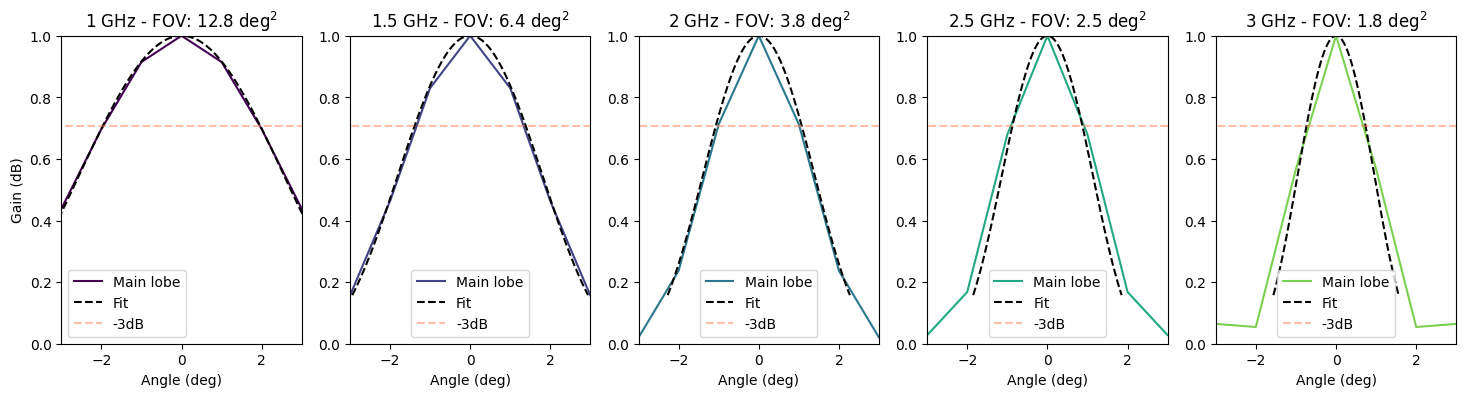

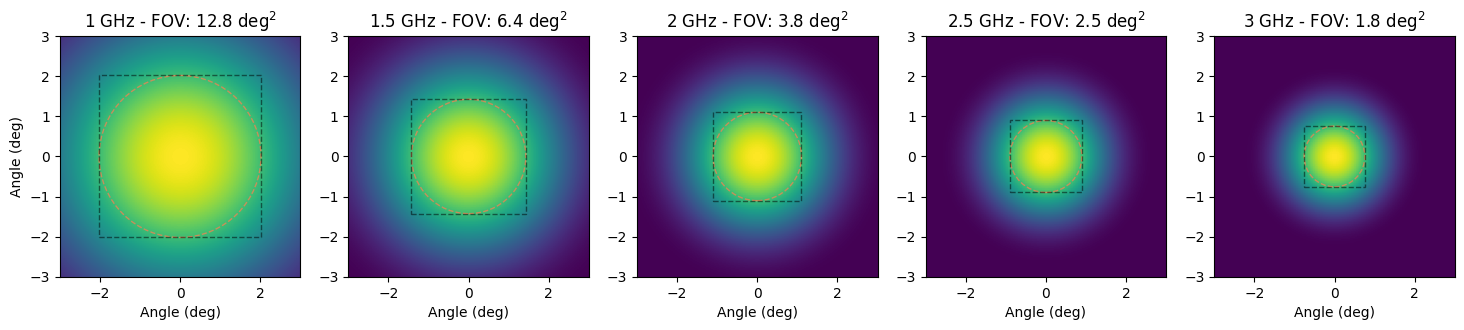

In [5]:
fig, ax = plt.subplots(1,5, figsize=(18,4))
fig_fov, ax_fov = plt.subplots(1,5, figsize=(18,4))

bm_width = 4
FOV_max = 6
fit_n = 100

# c_list = [0.125, 0.12, 0.115, 0.10, 0.10]
c_list = [0.2]*5

FOV_list = []

for i, beam in enumerate(norm_beam_list):
    bm_centre = np.argmax(beam[:,2])
    bm_peak = np.max(beam[:,2])
    color_ = cmap(i/n_freq)
    ax[i].plot(beam[bm_centre-bm_width:bm_centre+bm_width+1 ,0], beam[bm_centre-bm_width:bm_centre+bm_width+1 ,2], label='Main lobe', color=color_)
    
    f = freq_np[i]
    C_f = c_list[i] * f + c_list[i]**2
    x = np.linspace(-1/C_f, 1/C_f, fit_n)
    ax[i].plot(x, np.cos(C_f*x)**3, color='k', linestyle='--', label='Fit')

    ax[i].hlines(1/np.sqrt(2), -FOV_max, FOV_max, linestyle='--', color='coral', alpha=0.5, label='-3dB')

    fit_bw = np.abs(fit_n//2 - np.argmin((np.cos(C_f*x)**3 - (1/np.sqrt(2)))**2))*2
    r_fov = (x[fit_bw] - x[0])/2
    print(r_fov)
    r_fov_theo = np.arccos((1/np.sqrt(2))**(1/3))/C_f
    max_fov_theo = np.arccos((.5)**(1/3))/C_f
    print(r_fov_theo, max_fov_theo)
    FOV = np.pi * r_fov**2
    FOV_list.append(FOV)

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(-FOV_max/2, FOV_max/2)
    ax[i].set_title(freq_labels[i]+r' - FOV: {:.1f} $\deg^2$'.format(FOV))
    ax[i].legend()
    ax[i].set_xlabel('Angle (deg)')
    if i == 0:
        ax[i].set_ylabel('Gain (dB)')


    l, m = np.meshgrid(np.linspace(-FOV_max/2, FOV_max/2, fit_n), np.linspace(-FOV_max/2, FOV_max/2, fit_n))
    z = np.cos(C_f*np.sqrt(l**2 + m**2))**3
    ax_fov[i].imshow(z, extent=(-FOV_max/2, FOV_max/2, -FOV_max/2, FOV_max/2), vmin=0, vmax=1)
    
    ax_fov[i].set_xlabel('Angle (deg)')
    if i == 0:
        ax_fov[i].set_ylabel('Angle (deg)')
    ax_fov[i].set_title(freq_labels[i]+r' - FOV: {:.1f} $\deg^2$'.format(FOV))

    fov_contour = plt.Circle((0,0), r_fov, color='coral', alpha=0.7, linestyle='--', fill=False)
    fov_crop = plt.Rectangle((-r_fov, -r_fov), 2*r_fov, 2*r_fov, color='k', alpha=0.5, linestyle='--', fill=False)
    ax_fov[i].add_artist(fov_contour)
    ax_fov[i].add_artist(fov_crop)




# Synthetic Primary Beam

Using the `CosCubeBeam` class from the `argosim.beam_utils` module.

In [ ]:
from argosim.beam_utils import *
beam = CosCubeBeam(c=.2, f=3., n_pix=512, fov_deg=1.73)

### Compare beam fit to the beam data

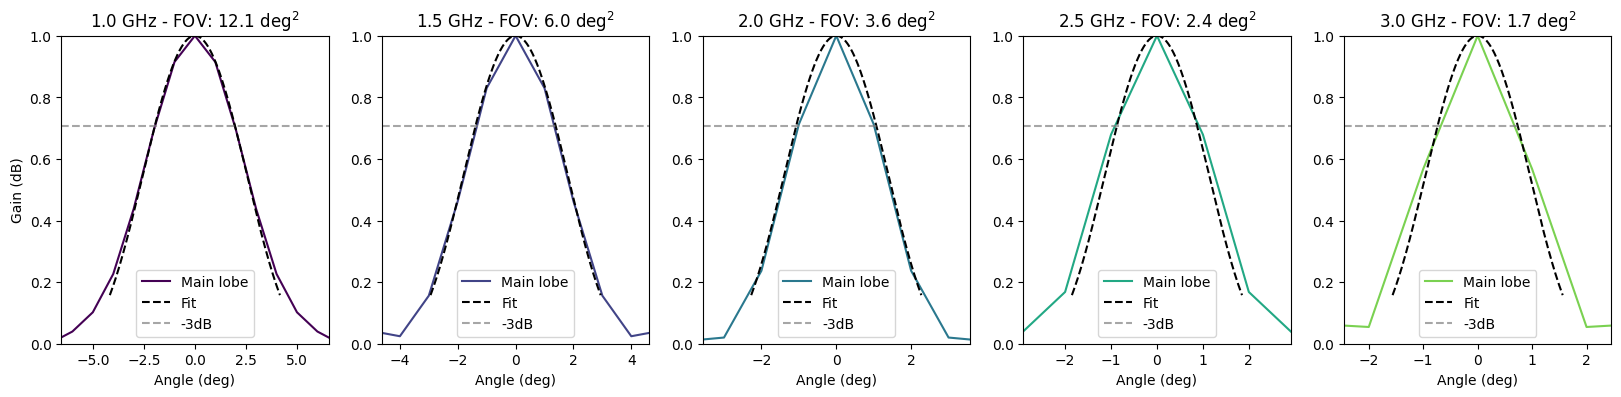

In [6]:
beam.evaluate_beam_fit(freq_np, norm_beam_list)

### Plot the beam in 1D as a function of the angle

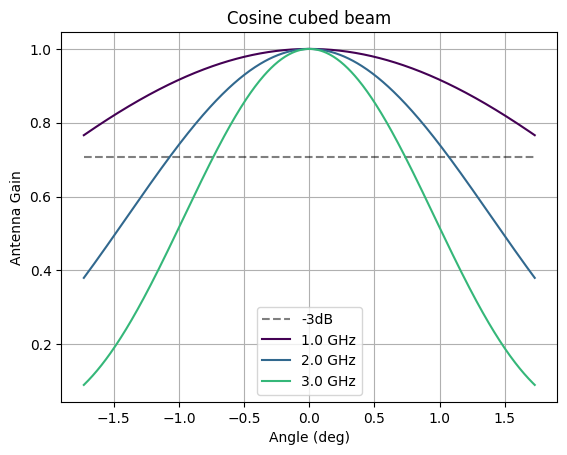

In [7]:
beam.plot_beam_1d([1., 2., 3.])

### Plot the beam in 2D

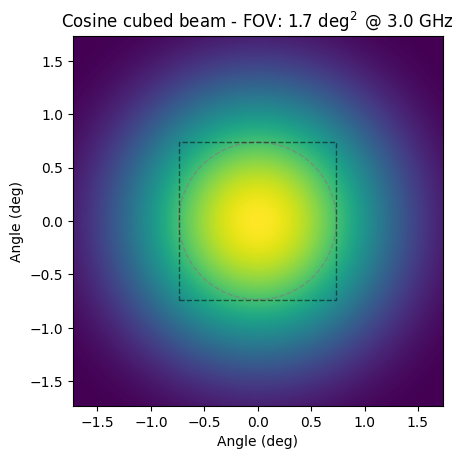

In [8]:
beam.plot_beam_2d()